<a href="https://colab.research.google.com/github/JvitorS23/notebooks-PIBIC/blob/master/semantic_segmentation_keras_gpu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!nvidia-smi

Mon Jun 15 18:22:03 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P0    59W / 149W |   4565MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Imports


In [0]:
import matplotlib.pyplot as plt 
import matplotlib as mpl
import numpy as np
import PIL
from PIL import Image
import os
import glob
import time
import datetime
import cv2
import random
import pandas as pd


# Keras Libraries
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, UpSampling2D, Dropout
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.python.client import device_lib
import tensorflow as tf
from keras.callbacks import ModelCheckpoint
from keras.callbacks import CSVLogger


#Pytorch Libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.datasets as dsets
from torchvision import models
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchsummary import summary

# Preparação do dataset


In [0]:
# monta o google drive
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!unzip /content/drive/My\ Drive/dataset-ufpr.zip

In [0]:
!rm -r dataset-ufpr/

In [0]:
def data_gen(img_folder, mask_folder, batch_size):
  c = 0
  n = os.listdir(img_folder) #List of training images
  random.shuffle(n)
  
  while (True):
    img = np.zeros((batch_size, 224, 224, 3)).astype('float')
    mask = np.zeros((batch_size, 224, 224, 1)).astype('float')

    for i in range(c, c+batch_size): #initially from 0 to 16, c = 0. 

      train_img = cv2.imread(img_folder+'/'+n[i])/255.
      # train_img =  cv2.resize(train_img, (512, 512))# Read an image from folder and resize
      
      img[i-c] = train_img #add to array - img[0], img[1], and so on.
                                                   

      train_mask = cv2.imread(mask_folder+'/'+n[i], cv2.IMREAD_GRAYSCALE)/255.
      # train_mask = cv2.resize(train_mask, (512, 512))
      train_mask = train_mask.reshape(224, 224, 1) # Add extra dimension for parity with train_img size [512 * 512 * 3]

      mask[i-c] = train_mask

    c+=batch_size
    if(c+batch_size>=len(os.listdir(img_folder))):
      c=0
      random.shuffle(n)
                  # print "randomizing again"
    yield img, mask

def get_names(root_dir):
  level1 = sorted(os.listdir(root_dir))
  img_names = list()
  tgt_names = list()
  for dirs in level1:
    img_names += sorted(glob.glob(os.path.join(root_dir,dirs,"**.png")))
    tgt_names += sorted(glob.glob(os.path.join(root_dir,dirs,"**.txt")))
  return list(zip(img_names,tgt_names))

def get_positions(name):
    f = open(name)
    for line in f:
      if 'position_vehicle:' in line:
        aux = line.replace('position_vehicle:', '').replace('\n', '').split()
        vehicle_box = tuple(map(int, aux))
      if 'position_plate:' in line:
        aux = line.replace('position_plate:', '').replace('\n', '').split()
        plate_box = tuple(map(int, aux))
    return vehicle_box, plate_box

def create_dataset_masks():
  os.makedirs('dataset/train/original_images')
  os.makedirs('dataset/train/mask_images')
  os.makedirs('dataset/val/original_images')
  os.makedirs('dataset/val/mask_images')
  os.makedirs('dataset/test/original_images')
  os.makedirs('dataset/test/mask_images')

  root_dir = '/content/UFPR-ALPR/'
  dirs = {
      'train': root_dir + 'training',
      'val': root_dir + 'validation',
      'test': root_dir + 'testing'
  }
 
  for dir in dirs:

    nomes = get_names(dirs[dir])
    i = 0

    for sample in nomes:
      image_path = sample[0]
      target_path = sample[1]

      image = Image.open(image_path)
      vehicle_position, plate_position = get_positions(target_path)
      x1,y1 = vehicle_position[1],vehicle_position[0]
      x2,y2 = x1+vehicle_position[3],y1+vehicle_position[2]
      vehicle_image = np.asarray(image)[x1:x2,y1:y2,:]   

      x1,y1 = plate_position[1]-x1,plate_position[0]-y1
      x2,y2 = x1+plate_position[3],y1+plate_position[2]
      plate_mask = np.zeros_like(vehicle_image)
      plate_mask[x1:x2,y1:y2,:] = 255
     
      target = Image.fromarray(plate_mask)
      vehicle_image = Image.fromarray(vehicle_image)     
      target = target.convert('L')
      target = target.resize((224,224))
      vehicle_image = vehicle_image.resize((224,224))

      target.save('/content/dataset/'+dir+'/mask_images/veiculo'+str(i)+'.png')
      vehicle_image.save('/content/dataset/'+dir+'/original_images/veiculo'+str(i)+'.png')
      i = i+1
    print(dir+' images done')     




# Definição do Modelo Unet_UFPR

Implementação usando Pytorch

In [0]:
class UNet_UFPR(nn.Module):
    def __init__(self):
        super(UNet_UFPR, self).__init__()
        self.conv2d_01 = nn.Conv2d(3, 16, 3, padding=1, stride=1)
        self.conv2d_02 = nn.Conv2d(16, 32, 3, stride=1)
        self.conv2d_03 = nn.Conv2d(32, 64, 3, stride=2)
        self.conv2d_04 = nn.Conv2d(64, 128, 3, stride=2)
        self.conv2d_05 = nn.Conv2d(128, 256, 3, stride=2)
        self.conv2d_06 = nn.Conv2d(256, 512, 3, stride=2)
        self.conv2d_07 = nn.ConvTranspose2d(512, 256, 3, stride=2)
        self.conv2d_08 = nn.ConvTranspose2d(256, 128, 3, stride=2)
        self.conv2d_09 = nn.ConvTranspose2d(128, 64, 3, stride=2)
        self.conv2d_10 = nn.ConvTranspose2d(64, 32, 3, stride=2)
        self.conv2d_11 = nn.ConvTranspose2d(32, 16, 3, stride=1)
        self.conv2d_12 = nn.ConvTranspose2d(16, 1, 3, stride=1, padding=1)
        


    def forward(self, x):
        out = F.relu(self.conv2d_01(x))
        out = F.relu(self.conv2d_02(out))
        out = F.max_pool2d (out,kernel_size=2,stride=2)
        out = F.relu(self.conv2d_03(out))
        out = F.dropout2d(out,0.6)
        out = F.relu(self.conv2d_04(out))
        out = F.relu(self.conv2d_05(out))
        out = F.relu(self.conv2d_06(out))
        out = F.relu(self.conv2d_07(out))
        out = F.relu(self.conv2d_08(out))
        out = F.relu(self.conv2d_09(out))
        out = F.relu(self.conv2d_10(out))
        out = F.dropout2d(out,.6)
        out = F.interpolate(out,scale_factor=2)
        out = F.relu(self.conv2d_11(out))
        # out = F.relu(self.conv2d_12(out))
        out = torch.sigmoid(self.conv2d_12(out))
        return out

Implementação usando Keras

In [0]:
def create_UNet_UFPR():
  
  #create model
  model = Sequential()

  #add model layers

  #Conv2D_1
  model.add(Conv2D(16, kernel_size=3, strides=1, activation='relu', padding="same", input_shape=(224,224,3)))

  #Conv2D_2
  model.add(Conv2D(32, kernel_size=3, strides=1, activation='relu', padding="valid"))

  #MaxPool2D
  model.add(MaxPooling2D(pool_size=(2,2), strides=2))

  #Conv2D_3
  model.add(Conv2D(64, kernel_size=3, strides=2, activation='relu', padding="valid"))

  #Dropout_1
  model.add(Dropout(0.6))

  #Conv2D_4
  model.add(Conv2D(128, kernel_size=3, strides=2, activation='relu', padding="valid"))

  #Conv2D_5
  model.add(Conv2D(256, kernel_size=3, strides=2, activation='relu', padding="valid"))

  #Conv2D_6
  model.add(Conv2D(512, kernel_size=3, strides=2, activation='relu', padding="valid"))

  #Conv2D_7
  model.add(Conv2DTranspose(256, kernel_size=3, strides=2, activation='relu', padding="valid"))

  #Conv2D_8
  model.add(Conv2DTranspose(128, kernel_size=3, strides=2, activation='relu', padding="valid"))

  #Conv2D_9
  model.add(Conv2DTranspose(64, kernel_size=3, strides=2, activation='relu', padding="valid"))

  #Conv2D_10
  model.add(Conv2DTranspose(32, kernel_size=3, strides=2, activation='relu', padding="valid"))

  #Dropout_2
  model.add(Dropout(0.6))

  #Interpolate
  model.add(UpSampling2D(size=(2, 2), interpolation="nearest"))

  #Conv2D_11
  model.add(Conv2DTranspose(16, kernel_size=3, strides=1, activation='relu', padding="valid"))

  #Conv2D_12
  model.add(Conv2DTranspose(1, kernel_size=3, strides=1, activation='sigmoid', padding="same"))

  return model

# Comparação da implementação Pytorch vs Keras

In [0]:
# Pytorch Implementation
summary(UNet_UFPR(), input_size=(3, 224, 224), batch_size=16, device='cpu')  

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [16, 16, 224, 224]             448
            Conv2d-2         [16, 32, 222, 222]           4,640
            Conv2d-3           [16, 64, 55, 55]          18,496
            Conv2d-4          [16, 128, 27, 27]          73,856
            Conv2d-5          [16, 256, 13, 13]         295,168
            Conv2d-6            [16, 512, 6, 6]       1,180,160
   ConvTranspose2d-7          [16, 256, 13, 13]       1,179,904
   ConvTranspose2d-8          [16, 128, 27, 27]         295,040
   ConvTranspose2d-9           [16, 64, 55, 55]          73,792
  ConvTranspose2d-10         [16, 32, 111, 111]          18,464
  ConvTranspose2d-11         [16, 16, 224, 224]           4,624
  ConvTranspose2d-12          [16, 1, 224, 224]             145
Total params: 3,144,737
Trainable params: 3,144,737
Non-trainable params: 0
---------------------------

In [0]:
# Keras Implementation
model = create_UNet_UFPR()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 16)      448       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 222, 222, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 55, 55, 64)        18496     
_________________________________________________________________
dropout_1 (Dropout)          (None, 55, 55, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 27, 27, 128)       73856     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 13, 13, 256)      

# Treinamento

In [0]:
# scheduler for lr
def scheduler(epoch, lr):
  if epoch>0 and epoch % 10 == 0:
    return lr/5
  else:
    return lr

In [0]:
train_image_path = '/content/dataset-ufpr/train/original_images'
train_mask_path = '/content/dataset-ufpr/train/mask_images'
val_image_path = '/content/dataset-ufpr/val/original_images'
val_mask_path = '/content/dataset-ufpr/val/mask_images'
save_path = '/content/best_model.h5'

num_of_train_images = len(os.listdir('/content/dataset-ufpr/train/original_images'))
num_of_val_images = len(os.listdir('/content/dataset-ufpr/val/original_images'))
num_epochs = 50
batch_size = 32

with tf.device('/device:GPU:0'):
  train_gen = data_gen(train_image_path,train_mask_path, batch_size)
  val_gen = data_gen(val_image_path,val_mask_path, batch_size)
  optim = keras.optimizers.RMSprop(learning_rate=0.001)

  #create model
  model = create_UNet_UFPR()

  #compile model
  model.compile(loss='binary_crossentropy', optimizer=optim)

  checkpoint = ModelCheckpoint(save_path, monitor='loss', verbose=1, save_best_only=True, mode='min')

  csv_logger = CSVLogger('./train_log.csv', append=True, separator=';')

  # lr_scheduler = LearningRateScheduler(scheduler)

  callbacks_list = [checkpoint, csv_logger]

  history = model.fit_generator(train_gen, epochs=num_epochs, 
                            steps_per_epoch = (num_of_train_images//batch_size),
                            validation_data=val_gen, 
                            validation_steps=(num_of_val_images//batch_size), 
                            callbacks=callbacks_list)
  model.save('Model.h5')

Epoch 1/50
56/56 [==============================] - 20s 362ms/step - loss: 0.6787 - val_loss: 0.1122

Epoch 00001: loss improved from inf to 0.67870, saving model to /content/best_model.h5
Epoch 2/50
56/56 [==============================] - 19s 334ms/step - loss: 0.1191 - val_loss: 0.0987

Epoch 00002: loss improved from 0.67870 to 0.11914, saving model to /content/best_model.h5
Epoch 3/50
56/56 [==============================] - 19s 331ms/step - loss: 0.0846 - val_loss: 0.0632

Epoch 00003: loss improved from 0.11914 to 0.08464, saving model to /content/best_model.h5
Epoch 4/50
56/56 [==============================] - 18s 329ms/step - loss: 0.0577 - val_loss: 0.0527

Epoch 00004: loss improved from 0.08464 to 0.05772, saving model to /content/best_model.h5
Epoch 5/50
56/56 [==============================] - 18s 330ms/step - loss: 0.0335 - val_loss: 0.0440

Epoch 00005: loss improved from 0.05772 to 0.03347, saving model to /content/best_model.h5
Epoch 6/50
56/56 [=====================

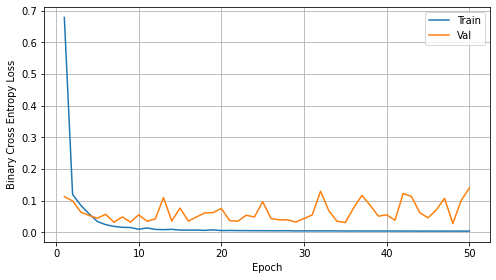

In [0]:
df = pd.read_csv('/content/train_log.csv', header=None, sep=';')

train_loss = df[1].iloc[0:][1:].astype('float')
val_loss = df[2].iloc[0:][1:].astype('float')
# plotar tudo
mpl.rcParams['figure.figsize'] = (7, 4) #fig size
mpl.rcParams['axes.grid'] = False
train_loss.plot(label='Train')  
val_loss.plot(label='Val')
plt.xlabel('Epoch')
plt.ylabel('Binary Cross Entropy Loss')
plt.grid(True, which='both', axis='both')  
plt.tight_layout()
plt.legend()


In [0]:
#evaluate the model
test_image_path = '/content/dataset-ufpr/test/original_images'
test_mask_path = '/content/dataset-ufpr/test/mask_images'
num_of_test_images = len(os.listdir('/content/dataset-ufpr/test/original_images'))

test_gen = data_gen(test_image_path,test_mask_path, batch_size)

#load the model
model = create_UNet_UFPR()
model.load_weights('/content/best_model.h5')

# evaluate loaded model on test data
model.compile(loss='binary_crossentropy', optimizer='rmsprop')
score = model.evaluate(test_gen, verbose=1, steps=num_of_test_images//batch_size)

print(model.metrics_names)
print(score)


56/56 [==============================] - 8s 150ms/step
['loss']
0.11557570099830627


# Predição



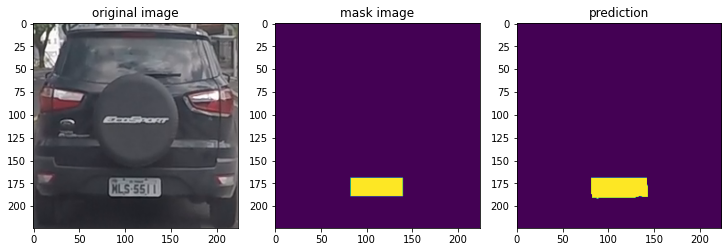

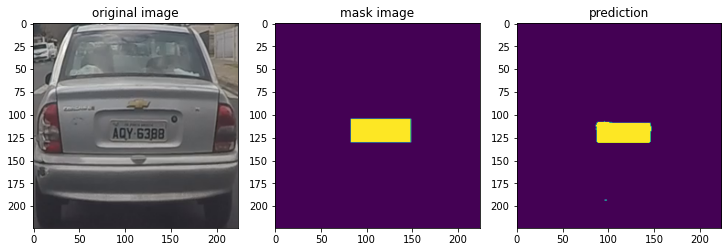

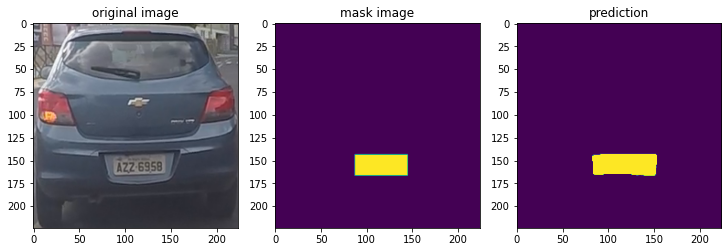

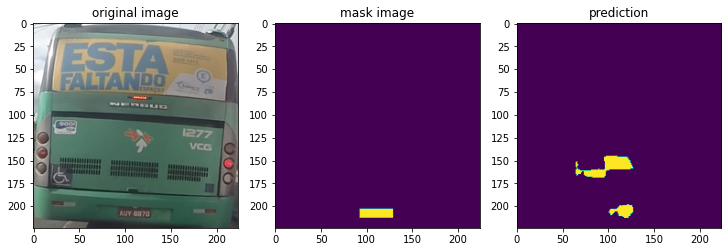

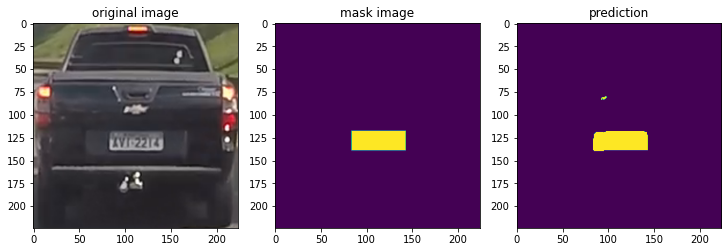

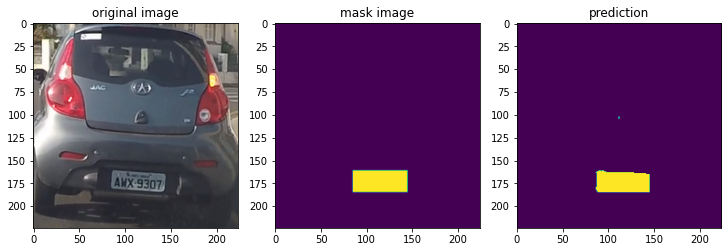

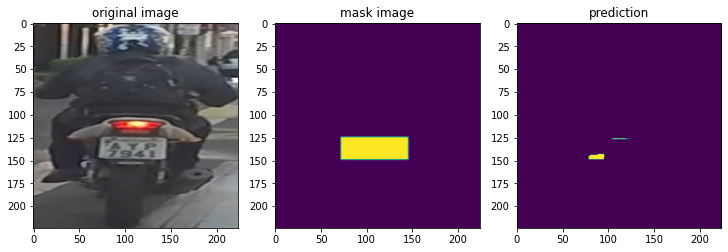

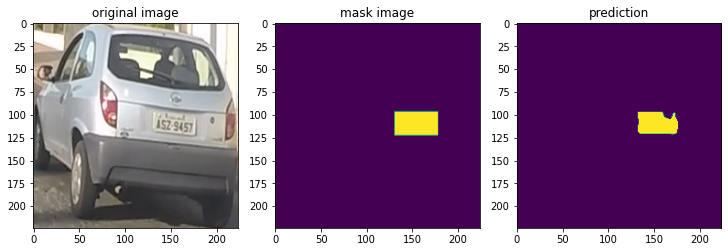

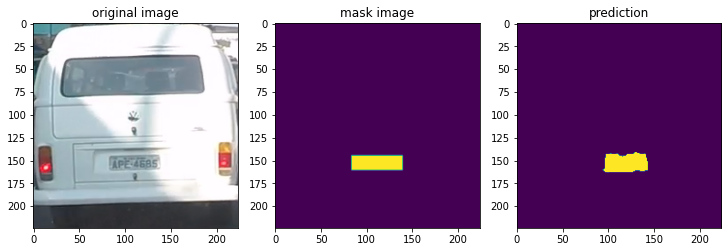

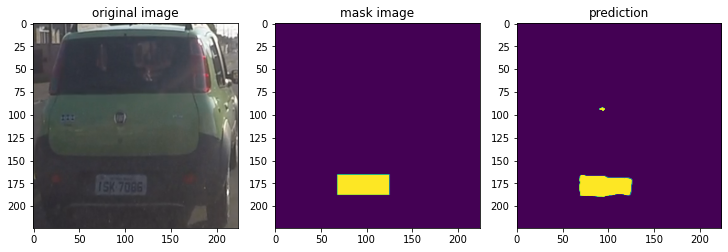

In [0]:
%matplotlib inline
#load the model
model = create_UNet_UFPR()
model.load_weights('/content/best_model.h5')

for i in range(10):
  input_image = load_img("/content/dataset-ufpr/test/original_images/veiculo"+ str(i*30)+".png")
  input_arr = img_to_array(input_image)
  input_arr = np.array([input_arr])  # Convert single image to a batch.
  predictions = model.predict(input_arr)

  fig, axs = plt.subplots(1, 3, figsize=(10, 10), constrained_layout=True)

  img_orig = input_image
  axs[0].imshow(img_orig)
  axs[0].set_title('original image')
  axs[0].grid(False)

  mask_image = "/content/dataset-ufpr/test/mask_images/veiculo"+ str(i*30)+".png"
  axs[1].imshow(Image.open(mask_image))
  axs[1].set_title('mask image')
  axs[1].grid(False)

  pred = predictions[0].reshape(224,224)
  axs[2].imshow(pred)
  axs[2].set_title('prediction')
  axs[2].grid(False)
